# Measuring spatial distribution

Spatial distribution can be captured many ways. This notebook show couple of them, based on orientation and street corridor.

In [1]:
import matplotlib.pyplot as plt
import momepy
import osmnx as ox

In [11]:
gdf = ox.features_from_place("Kahla, Germany", tags={"building": True})
buildings = ox.projection.project_gdf(gdf).reset_index(drop=True)

limit = momepy.buffered_limit(buildings)
tess = momepy.morphological_tessellation(buildings, clip=limit)
tessellation = tess.to_frame("geometry")

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/features.py:294: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


In [19]:
streets_graph = ox.graph_from_place("Kahla, Germany", network_type="drive")
streets_graph = ox.projection.project_graph(streets_graph)
edges = ox.graph_to_gdfs(
    streets_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)

/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/graph.py:392: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


## Alignment

We can measure alignment of different elements to their neighbours (for which `Graph` is needed) or to different elements. We will explore cell alignment (difference of orientation of buildings and cells) and street alignment (difference of orientation of buildings and street segments).

### Cell alignment

For `cell_alignment` we need to know orientations, so let's calculate them first. Orientation is defined as an orientation of the longext axis of bounding rectangle in range [0,45). It captures the deviation of orientation from cardinal directions:

In [13]:
buildings["orientation"] = momepy.orientation(buildings)
tessellation["orientation"] = momepy.orientation(tessellation)

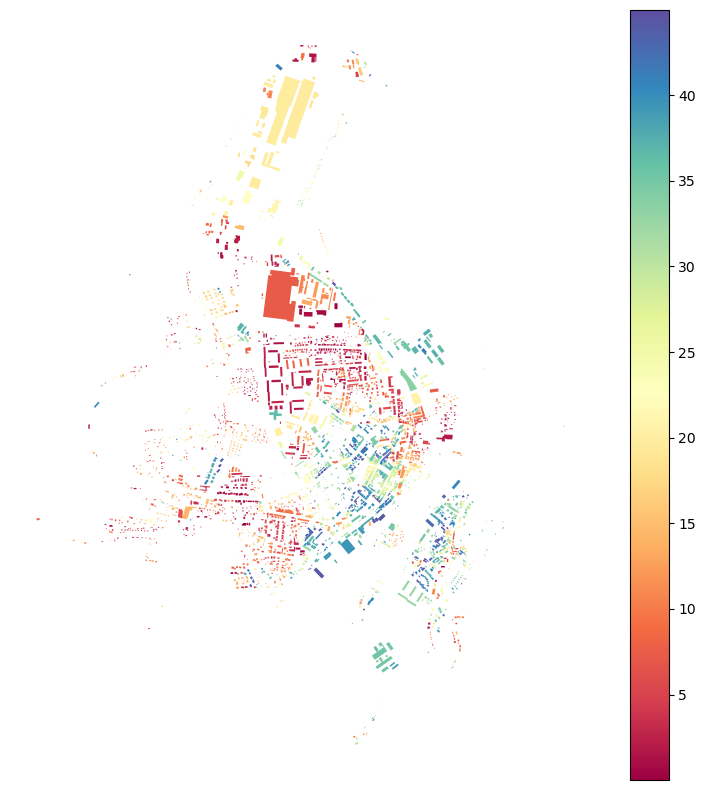

In [14]:
buildings.plot(
    column="orientation", legend=True, cmap="Spectral", figsize=(10, 10)
).set_axis_off()

`cell_alignment` requires both orientation arrays:

In [15]:
buildings["cell_align"] = momepy.cell_alignment(
    buildings.orientation, tessellation.orientation
)

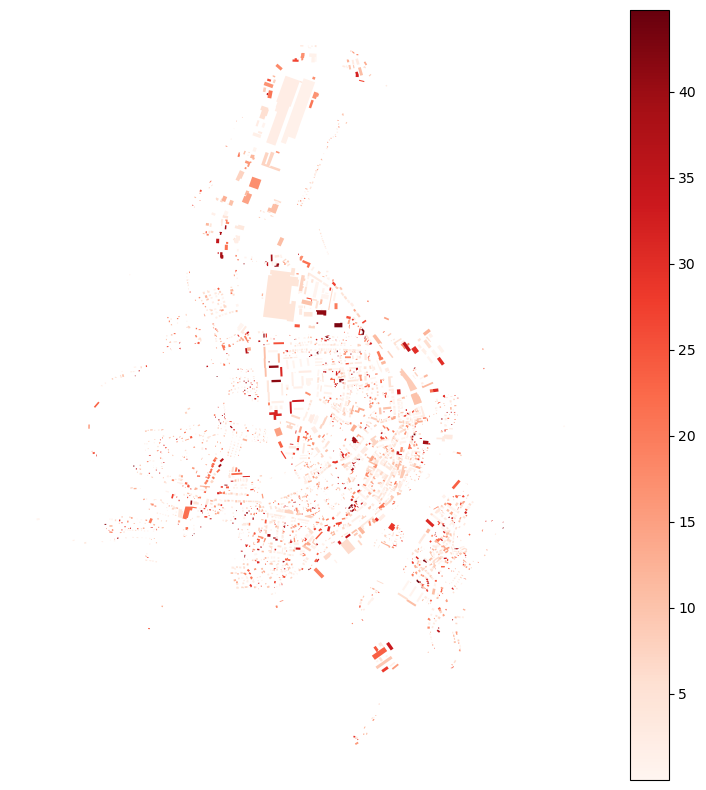

In [16]:
buildings.plot(
    column="cell_align", legend=True, cmap="Reds", figsize=(10, 10)
).set_axis_off()

No really clear pattern is visible in this case, but it might be in other, especially comparing building orientation with plots.

### Street alignment

Street alignment works on the same principle as cell alignment. What we do not have at this moment is street index linked to buildings:

In [21]:
buildings["street_index"] = momepy.get_nearest_street(buildings, edges)

`street_alignment` then requires orientations of both builings and streets and the index of the nearest street.

In [22]:
buildings["str_align"] = momepy.street_alignment(
    buildings.orientation, momepy.orientation(edges), buildings["street_index"]
)

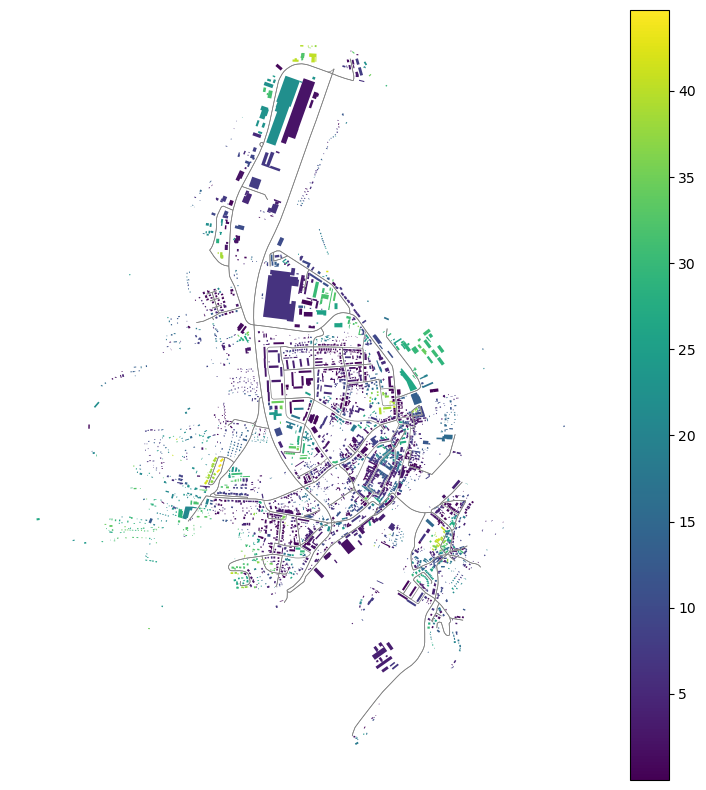

In [23]:
ax = edges.plot(color="grey", linewidth=0.5, figsize=(10, 10))
buildings.plot(ax=ax, column="str_align", legend=True)
ax.set_axis_off()

## Street profile

`street_profile` captures several characters at the same time. It generates a series of perpendicular ticks of set length and set spacing and returns mean widths of street profile, their standard deviation, mean height and its standard deviation, profile as a ratio of widht and height and degree of openness. If heights are not passed, it will not return them and profile. We will use Manhattan example to illustrate how it works. Building `height` column is converted to float and buildings are exploded to avoid multipolygons.

In [25]:
point = (40.731603, -73.977857)
dist = 1000
gdf = ox.features_from_point(point, dist=dist, tags={"building": True})
buildings = ox.projection.project_gdf(gdf)
buildings = buildings[buildings.geom_type.isin(["Polygon", "MultiPolygon"])]

In [26]:
def clean_heights(x):
    try:
        return float(x)
    except ValueError:
        return 0


buildings["height"] = buildings["height"].fillna(0).apply(clean_heights)
buildings = buildings.explode(ignore_index=True)

In [27]:
streets_graph = ox.graph_from_point(point, dist, network_type="drive")
streets_graph = ox.projection.project_graph(streets_graph)
edges = ox.graph_to_gdfs(
    streets_graph,
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index()

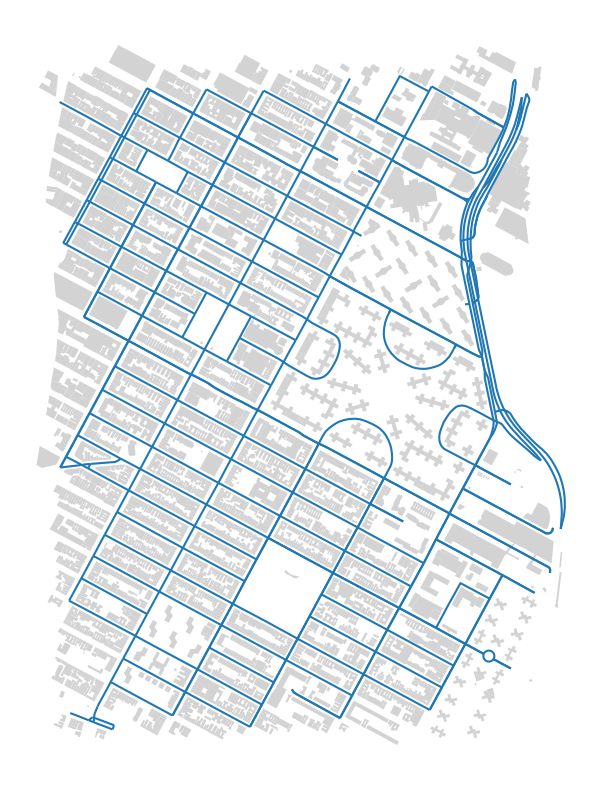

In [28]:
ax = buildings.plot(figsize=(10, 10), color="lightgrey")
edges.plot(ax=ax)
ax.set_axis_off()

In [29]:
profile = momepy.street_profile(edges, buildings, height=buildings["height"])

We can assign measrued characters as columns of edges gdf:

In [30]:
edges[profile.columns] = profile
edges[profile.columns].head()

,width,openness,width_deviation,height,height_deviation,hw_ratio
0,22.015871,0.416667,1.138172,16.178571,12.013273,0.734859
1,25.596680,0.233333,3.786193,23.421739,21.358412,0.915030
2,30.392740,0.555556,4.446756,20.625000,2.728029,0.678616
3,38.879126,0.750000,4.188487,19.000000,0.000000,0.488694
4,22.015871,0.416667,1.138172,16.178571,12.013273,0.734859


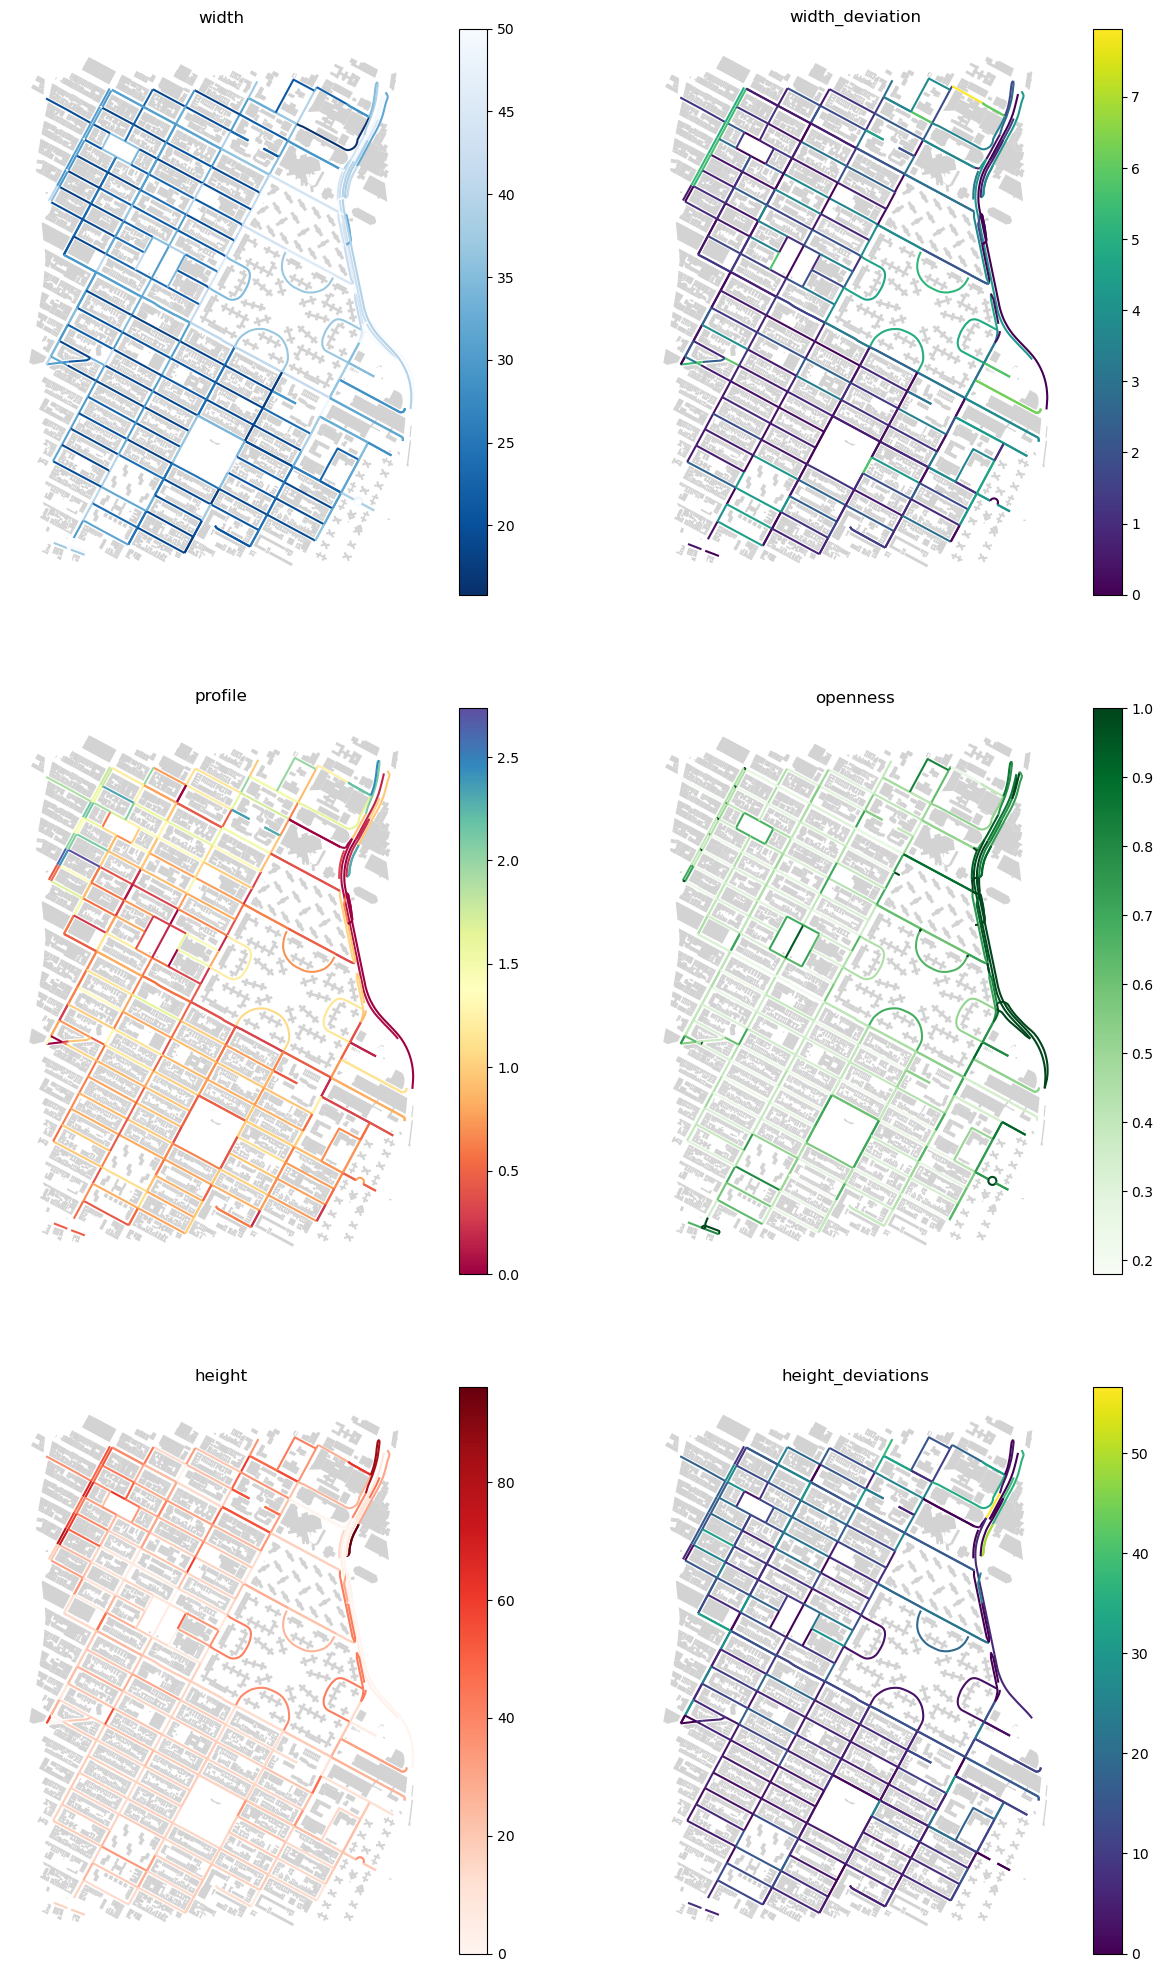

In [32]:
f, axes = plt.subplots(figsize=(15, 25), ncols=2, nrows=3)
edges.plot(ax=axes[0][0], column="width", legend=True, cmap="Blues_r")
buildings.plot(ax=axes[0][0], color="lightgrey")
edges.plot(ax=axes[0][1], column="width_deviation", legend=True)
buildings.plot(ax=axes[0][1], color="lightgrey")
axes[0][0].set_axis_off()
axes[0][0].set_title("width")
axes[0][1].set_axis_off()
axes[0][1].set_title("width_deviation")
edges.plot(ax=axes[1][0], column="hw_ratio", legend=True, cmap="Spectral")
buildings.plot(ax=axes[1][0], color="lightgrey")
edges.plot(ax=axes[1][1], column="openness", legend=True, cmap="Greens")
buildings.plot(ax=axes[1][1], color="lightgrey")
axes[1][0].set_axis_off()
axes[1][0].set_title("profile")
axes[1][1].set_axis_off()
axes[1][1].set_title("openness")
edges.plot(ax=axes[2][0], column="height", legend=True, cmap="Reds")
buildings.plot(ax=axes[2][0], color="lightgrey")
edges.plot(ax=axes[2][1], column="height_deviation", legend=True)
buildings.plot(ax=axes[2][1], color="lightgrey")
axes[2][0].set_axis_off()
axes[2][0].set_title("height")
axes[2][1].set_axis_off()
axes[2][1].set_title("height_deviations")